In [101]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rotate, resize, pad, crop
import random
import matplotlib.pyplot as plt

In [365]:
"""
Augmentations implementation, mostly designed for/inspired by dSprites

Parameters
----------
image: a PyTorch tensor defined by (# channels, height, width) shape
"""

# 1. rotation
def random_rotation(image):
    return rotate(image, random.randrange(0, 360))

# 2. scaling

# for any general image dataset, but note it might be good to consider specifics, like I did for dSprites
def get_rescaled_img_with_padding(image):
    scale_factor = random.uniform(0.5, 0.9)  # Adjust the range according to your needs
    new_width = int(image.shape[2] * scale_factor)
    new_height = int(image.shape[1] * scale_factor)
    resized_image = resize(image, (new_height, new_width))

    # Calculate padding values to maintain the original dimensions
    pad_left_amt = (image.shape[2] - new_width) // 2
    pad_top_amt = (image.shape[1] - new_height) // 2
    pad_right_amt = image.shape[2] - new_width - pad_left_amt
    pad_bottom_amt = image.shape[1] - new_height - pad_top_amt

    # Pad the resized image with black pixels
    # default fill value is 0
    padded_image = pad(resized_image, (pad_left_amt, pad_top_amt, pad_right_amt, pad_bottom_amt))

    return padded_image

# for dSprites, we want to preserve position while scaling the shape

def get_shape_bounds(image):
    """helper method to obtain bounding box of shape sprite"""
    white_pixels = image.nonzero(as_tuple=True)
    y_min, y_max = white_pixels[1].min(), white_pixels[1].max()
    x_min, x_max = white_pixels[2].min(), white_pixels[2].max()
    return x_min, x_max, y_min, y_max

def get_rescaled_shape_img(image):
    """shrinks a shape sprite while maintaining position
    and returns the corresponding image with the same dimensions as `image`"""
    ## Calculations
    x1, x2, y1, y2 = get_shape_bounds(image)
    # bounding box dimensions of sprite/shape
    shape_width, shape_height = x2 - x1 + 1, y2 - y1 + 1

    # scale_factor = random.uniform(0.6, 1.2)
    scale_factor = random.uniform(0.6, 0.9)
    # print("Scale factor: " + str(scale_factor))
    while scale_factor == 1.0:
        scale_factor = random.uniform(0.6, 0.9)

    new_width, new_height = int(shape_width * scale_factor), int(shape_height * scale_factor)

    # compute padding amounts in 4 directions
    left_pad_amt = (shape_width - new_width) // 2
    top_pad_amt = (shape_height - new_height) // 2
    right_pad_amt = shape_width - left_pad_amt - new_width
    bottom_pad_amt = shape_height - top_pad_amt - new_height 


    ## Applying our calculations 
    # crop out and resize the shape sprite itself
    rescaled_shape = resize(crop(image, left=x1, top=y1, width=shape_width, height=shape_height), (new_height, new_width))

    # applying padding to preserve center spot of shape
    padded_rescaled_shape = pad(rescaled_shape, (left_pad_amt, top_pad_amt, right_pad_amt, bottom_pad_amt))

    to_ret = torch.clone(image)

    to_ret[0, y1:y2+1, x1:x2+1] = padded_rescaled_shape
    return to_ret



# 3. Translation - dSprite-specific augmentation
def get_max_shift_amts(image):
    x_min, x_max, y_min, y_max = get_shape_bounds(image)
    max_shift_left = x_min
    max_shift_right = image.size(2) - x_max
    max_shift_up = y_min
    max_shift_down = image.size(1) - y_max
    return max_shift_left, max_shift_right, max_shift_up, max_shift_down


def get_translated_shape_img(image):
    """translates a shape sprite by a random, in-bound amount in the x and y directions
    and returns the corresponding image with the same dimensions as `image`"""
    ## Calculations
    x1, x2, y1, y2 = get_shape_bounds(image)
    msl, msr, msu, msd = get_max_shift_amts(image)

    shift_x = np.random.choice(np.append(np.arange(-msl, 0), np.arange(1, msr)))
    shift_y = np.random.choice(np.append(np.arange(-msu, 0), np.arange(1, msd)))

    print(shift_x, shift_y)

    ## Applying calculations 
    to_ret = torch.clone(image)

    # get shape, clear out original spot, and place shape in translated spot

    # this way, the 0 assignment afterwards doesn't affect shape_bbox too to become all 0s
    shape_bbox = torch.clone(to_ret[0, y1:y2+1, x1:x2+1])
    to_ret[0, y1:y2+1, x1:x2+1] = 0
    to_ret[0 , y1+shift_y : y2+1+shift_y , x1+shift_x : x2+1+shift_x] = shape_bbox

    return to_ret


# 4. Flipping (horizontal/vertical)

In [61]:
def convert_to_tripletBatch(batch):
    """"
    Translates Joseph Lee's honors thesis idea with data augmentation --> dataloader implementation 

    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = rotate(first_image, random.randrange(0, 360))

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        # the "second_image" here is the starting image of the batch
        # This is to address the out of bounds error
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = rotate(batch[batch_size-1], random.randrange(0, 360))
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = rotate(batch[0], random.randrange(0, 360))
        
    return images_batch


def convert_to_tripletBatch_debug(batch):
    """"
    Proccesses a PyTorch-default batch of data sequentially, which (in the form) of a list,
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of tensors representing images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    print("Here is the batch in `collate_fn`")
    print(batch)
    print("List of Tensor sizes in batch:")
    print([tensor.shape for tensor in batch])

    return convert_to_tripletBatch(batch)

In [62]:
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]

In [63]:
(1, *[3, 4])

(1, 3, 4)

# Toy Data Experimentation

In [64]:
images = torch.randn(5, 1, 3, 3)
dataset = ImageDataset(images)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=convert_to_tripletBatch_debug, shuffle=True)

for batch in dataloader:
    batch = batch.view(batch.shape[0]*batch.shape[1], *batch.shape[2:]) 
    print(f"Batch output with shape {batch.shape}")
    print(batch)
    print("\n\n")

Here is the batch in `collate_fn`
[tensor([[[-0.1454,  0.3644, -0.5285],
         [-0.6840, -1.7795,  0.9017],
         [-0.3752, -0.1773, -0.0122]]]), tensor([[[-2.2324, -0.2651,  0.5700],
         [ 0.8444,  0.8556,  0.5815],
         [ 0.3963, -0.2980,  1.2907]]])]
List of Tensor sizes in batch:
[torch.Size([1, 3, 3]), torch.Size([1, 3, 3])]
Batch size: 2
Batch output with shape torch.Size([6, 1, 3, 3])
tensor([[[[-0.1454,  0.3644, -0.5285],
          [-0.6840, -1.7795,  0.9017],
          [-0.3752, -0.1773, -0.0122]]],


        [[[ 0.3644, -0.5285,  0.9017],
          [-0.1454, -1.7795, -0.0122],
          [-0.6840, -0.3752, -0.1773]]],


        [[[-2.2324, -0.2651,  0.5700],
          [ 0.8444,  0.8556,  0.5815],
          [ 0.3963, -0.2980,  1.2907]]],


        [[[-2.2324, -0.2651,  0.5700],
          [ 0.8444,  0.8556,  0.5815],
          [ 0.3963, -0.2980,  1.2907]]],


        [[[-0.2651,  0.5700,  0.5815],
          [-2.2324,  0.8556,  1.2907],
          [ 0.8444,  0.3963,

In [65]:
images.shape

torch.Size([5, 1, 3, 3])

# CelebA

In [66]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)

    def __getitem__(self, index):
        path = self.imgs[index][0]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img


In [67]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/CelebA", 'transform': transform}
celeba_data = CustomImageFolder(**train_kwargs)

In [68]:
len(celeba_data)

202599

In [69]:
BATCH_SIZE = 5

In [70]:
celeba_dataloader = DataLoader(celeba_data, batch_size=BATCH_SIZE, 
                               collate_fn=convert_to_tripletBatch_debug, shuffle=True)

In [71]:
def show_triplets_in_batch(dataloader: DataLoader):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(BATCH_SIZE, 3, figsize=(15, 15))

    batch = next(iter(dataloader))
    titles = ['Image 1', 'Augmented 1', 'Image 2']

    for batch_idx, triplet in enumerate(batch):
        for triplet_idx, image in enumerate(triplet):
            axs[batch_idx, triplet_idx].imshow(torch.permute(image, (1, 2, 0)))
            axs[batch_idx, triplet_idx].set_title(titles[triplet_idx])

    fig.suptitle(f'Batch of {BATCH_SIZE} Triplets')

    plt.show()


Here is the batch in `collate_fn`
[tensor([[[0.1216, 0.1608, 0.1961,  ..., 0.1137, 0.1294, 0.0471],
         [0.1216, 0.1608, 0.1961,  ..., 0.1176, 0.1255, 0.0431],
         [0.1216, 0.1647, 0.2039,  ..., 0.1255, 0.1176, 0.0314],
         ...,
         [0.7098, 0.7176, 0.7373,  ..., 0.1412, 0.1412, 0.1059],
         [0.6941, 0.7020, 0.7216,  ..., 0.1490, 0.0941, 0.0549],
         [0.7216, 0.7137, 0.7412,  ..., 0.1216, 0.0627, 0.0431]],

        [[0.1804, 0.1882, 0.1922,  ..., 0.5529, 0.5569, 0.3686],
         [0.1804, 0.1882, 0.1922,  ..., 0.5608, 0.5529, 0.3490],
         [0.1804, 0.1882, 0.2000,  ..., 0.5686, 0.5412, 0.3255],
         ...,
         [0.4471, 0.4431, 0.4471,  ..., 0.1647, 0.1608, 0.1294],
         [0.4118, 0.4157, 0.4353,  ..., 0.1765, 0.1294, 0.1098],
         [0.4314, 0.4235, 0.4510,  ..., 0.1608, 0.1137, 0.1176]],

        [[0.4902, 0.4980, 0.5020,  ..., 0.9569, 0.9804, 0.9725],
         [0.4863, 0.4941, 0.4941,  ..., 0.9608, 0.9804, 0.9686],
         [0.5020, 0.502

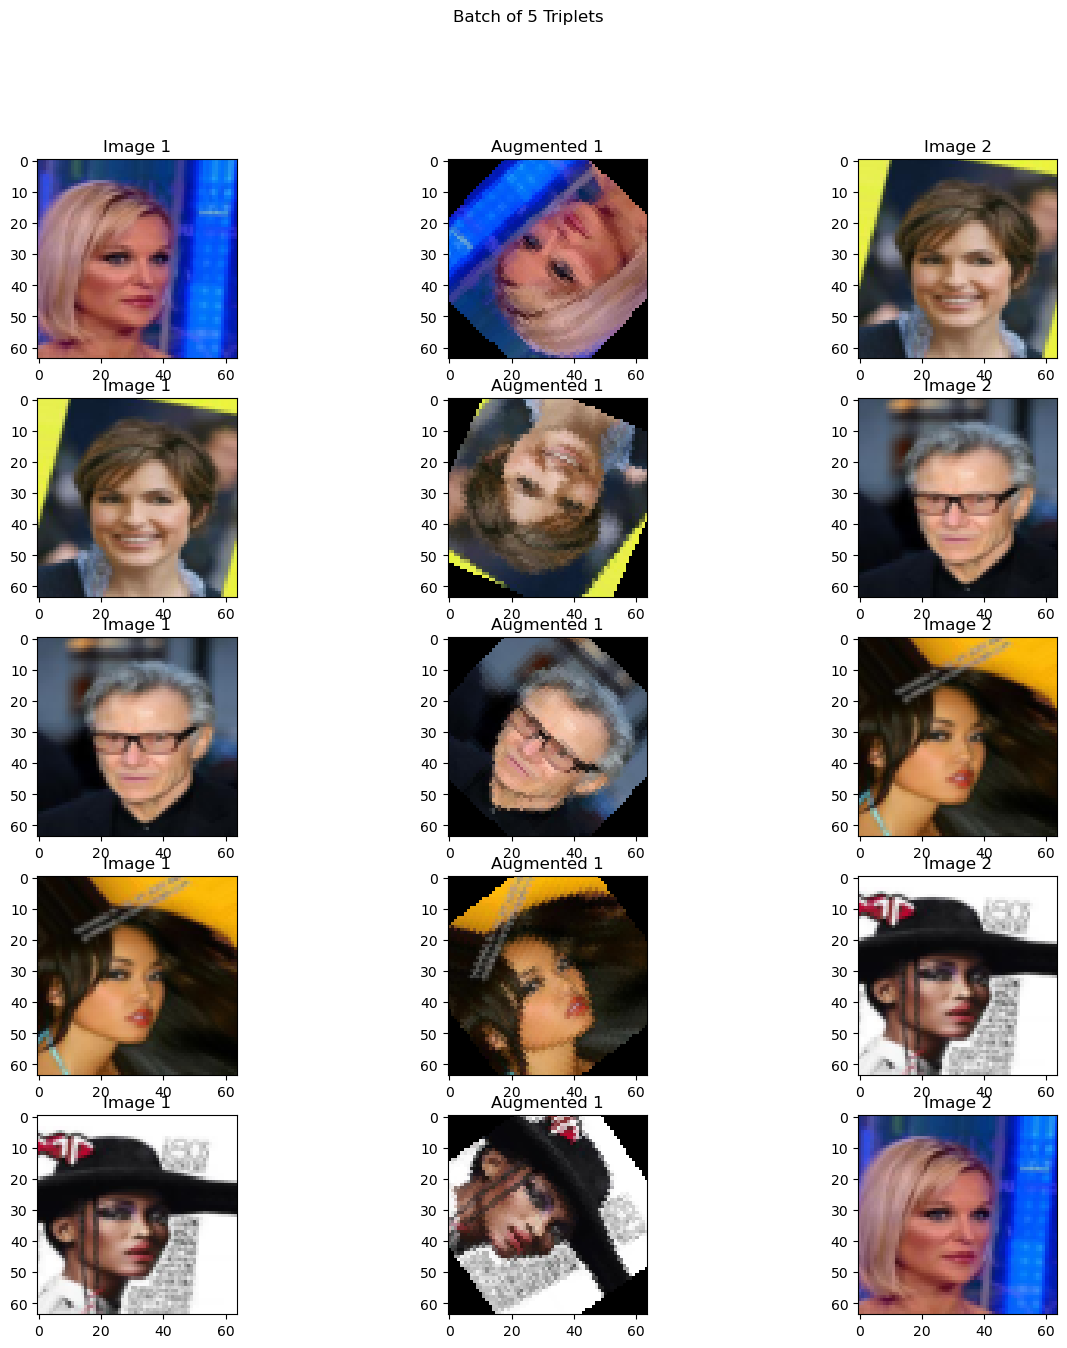

In [72]:
show_triplets_in_batch(celeba_dataloader)

# 3DChairs

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/3DChairs", 'transform': transform}
chairs3D_data = CustomImageFolder(**train_kwargs)

In [ ]:
chairs3D_dataloader = DataLoader(chairs3D_data, batch_size=BATCH_SIZE, 
                                 collate_fn=convert_to_tripletBatch, shuffle=True)

Batch size: 5


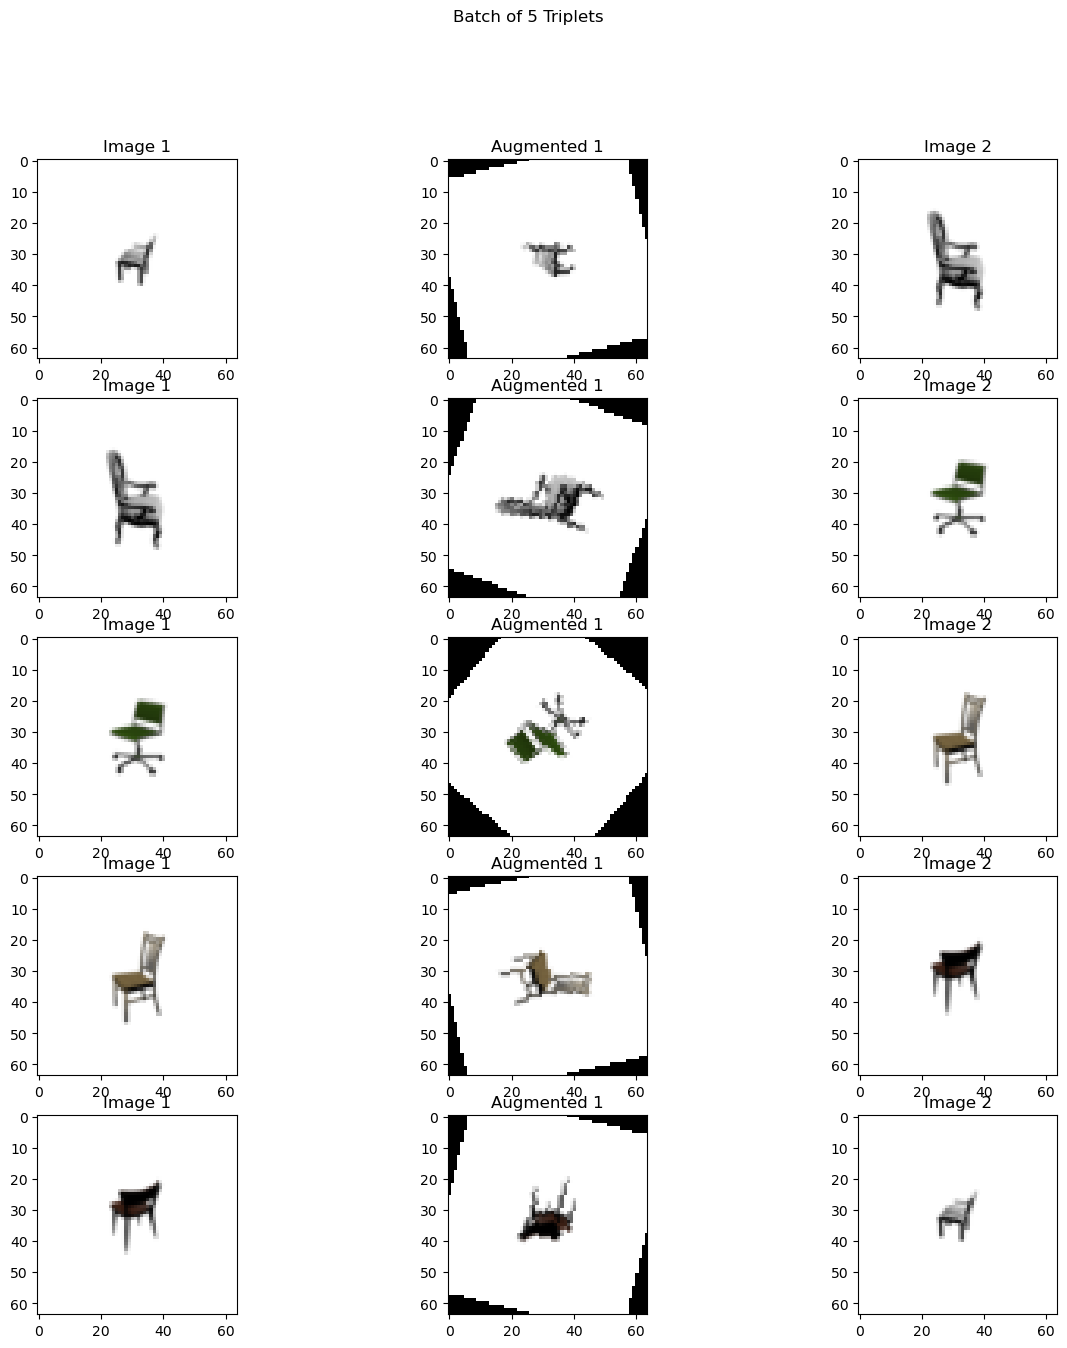

In [ ]:
show_triplets_in_batch(chairs3D_dataloader)

# dSprites

In [73]:
class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor):
        self.data_tensor = data_tensor

    def __getitem__(self, index):
        return self.data_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)


In [74]:
import numpy as np
dSprites_data = np.load("./data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz", encoding='bytes')
dSprites_data = torch.from_numpy(dSprites_data['imgs']).unsqueeze(1).float()

In [312]:
dSprites_dataset = CustomTensorDataset(data_tensor = dSprites_data)
dSprites_dataloader = DataLoader(dSprites_dataset, batch_size=BATCH_SIZE, 
                                 collate_fn=convert_to_tripletBatch_debug, shuffle=True)

Here is the batch in `collate_fn`
[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.]

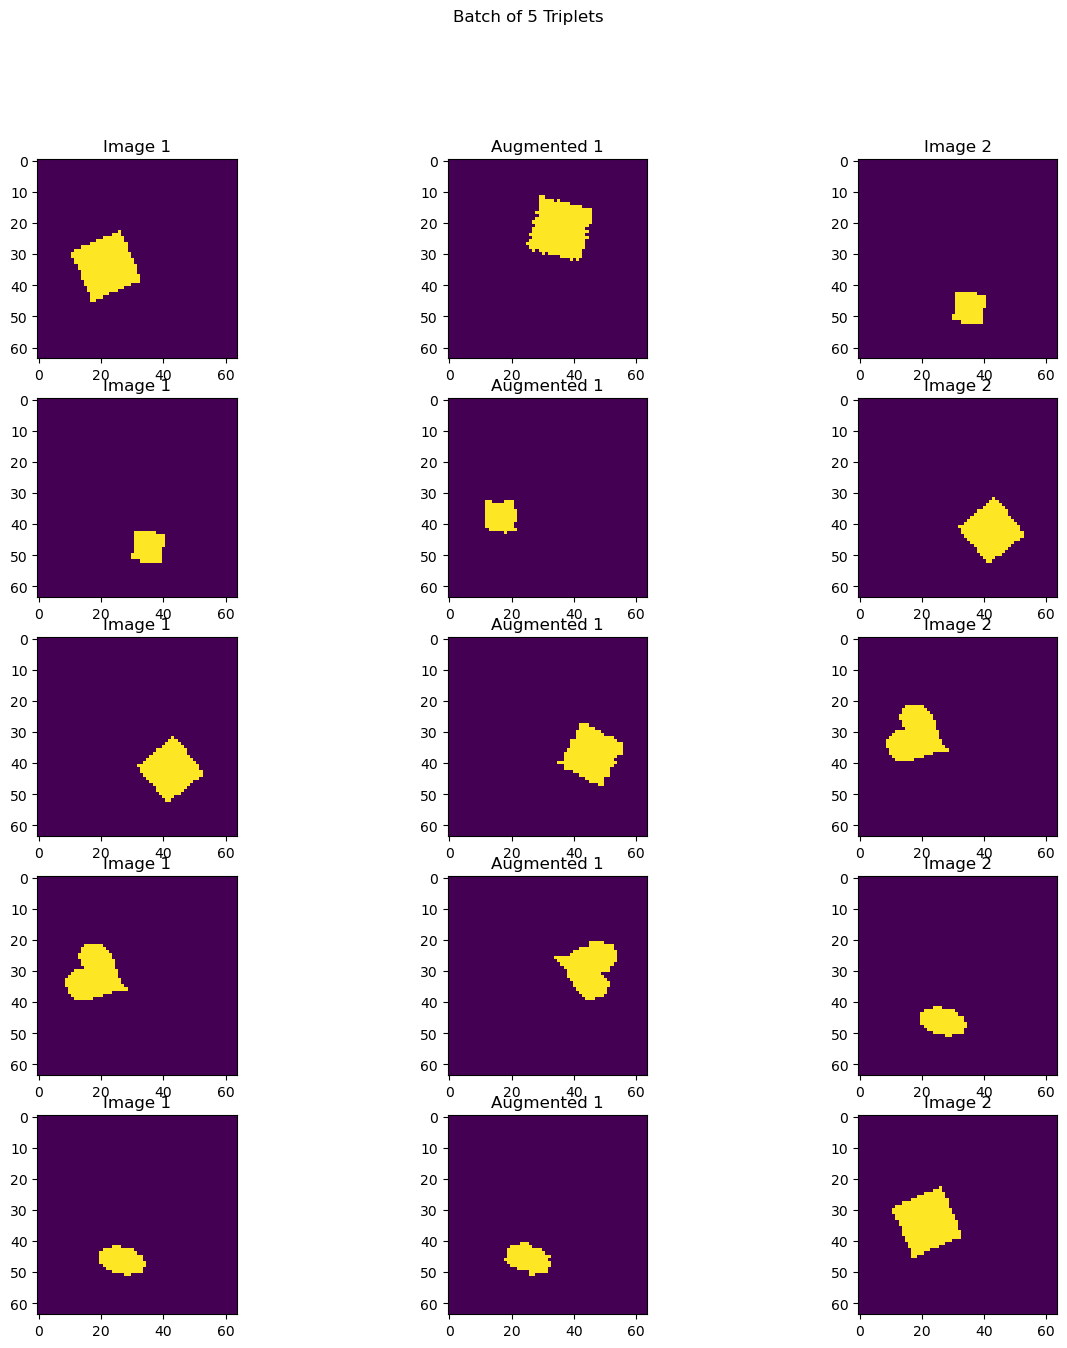

In [313]:
show_triplets_in_batch(dSprites_dataloader)

In [303]:
sample_ds_img = random.choice(dSprites_data)
shape_locs_tup = sample_ds_img.nonzero(as_tuple=True)
shape_locs_tup

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29,
         29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
         30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32,
         32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
         34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35,
         35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
         37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38

In [314]:
shape_bounds = get_shape_bounds(sample_ds_img)
shape_bounds

(tensor(26), tensor(38), tensor(27), tensor(39))

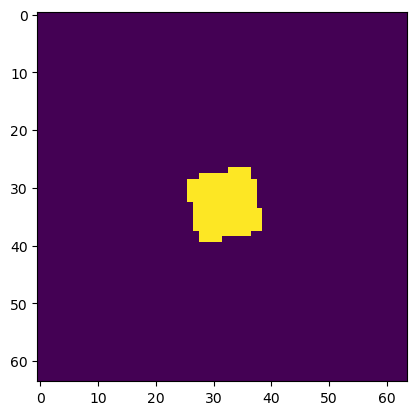

In [315]:
import matplotlib.pyplot as plt
plt.imshow(sample_ds_img.permute(1, 2, 0))

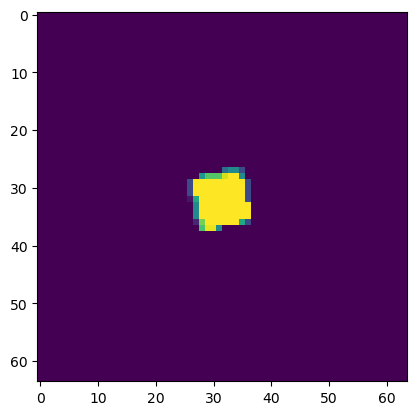

In [316]:
plt.imshow(get_rescaled_img_with_padding(sample_ds_img).permute(1, 2, 0))

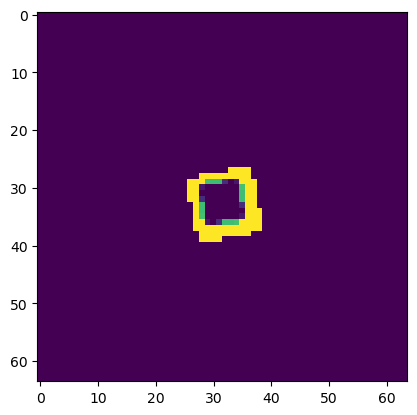

In [327]:

plt.imshow(sample_ds_img.permute(1,2,0) - get_rescaled_shape_img(sample_ds_img).permute(1, 2, 0))

-16 -18


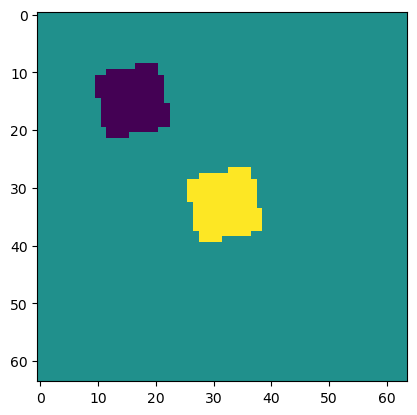

In [381]:
plt.imshow(sample_ds_img.permute(1,2,0) - get_translated_shape_img(sample_ds_img).permute(1, 2, 0))

In [366]:
(get_translated_shape_img(sample_ds_img) == 1).any()

-21 -10


tensor(True)